# ClickDetector use example
This algorithm detects the locations of impulsive noises (clicks and pops) on
the input audio frame. It relies on LPC coefficients to inverse-filter the
audio in order to attenuate the stationary part and enhance the prediction
error (or excitation noise)[1]. After this, a matched filter is used to
further enhance the impulsive peaks. The detection threshold is obtained from
a robust estimate of the excitation noise power [2] plus a parametric gain
value.

    References:
      [1] Vaseghi, S. V., & Rayner, P. J. W. (1990). Detection and suppression of
      impulsive noise in speech communication systems. IEE Proceedings I
      (Communications, Speech and Vision), 137(1), 38-46.
      [2] Vaseghi, S. V. (2008). Advanced digital signal processing and noise
      reduction. John Wiley & Sons. Page 355

In [7]:
import essentia.standard as es
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio 
from essentia import array as esarr
plt.rcParams["figure.figsize"] =(12,9)

In [8]:
def compute(x, frame_size=1024, hop_size=512, **kwargs):
    clickDetector = es.ClickDetector(frameSize=frame_size,
                                     hopSize=hop_size, 
                                     **kwargs)
    ends = []
    starts = []
    for frame in es.FrameGenerator(x, frameSize=frame_size,
                                   hopSize=hop_size, startFromZero=True):
        frame_starts, frame_ends = clickDetector(frame)

        for s in frame_starts:
            starts.append(s)
        for e in frame_ends:
            ends.append(e)

    return starts, ends

# Generating a click example

Lets start by degradating some audio files with some clicks of different amplitudes

Text(0.5,1,u'Signal with artificial clicks of different amplitudes')

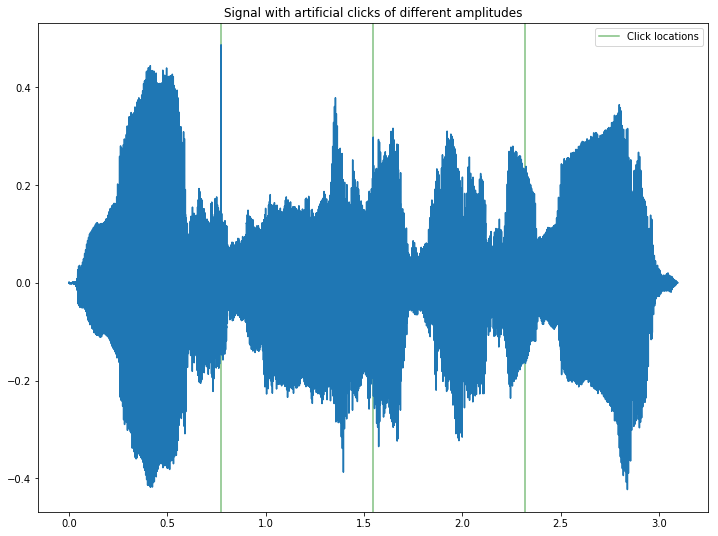

In [9]:
fs = 44100.

audio_dir = '../../audio/'
audio = es.MonoLoader(filename='{}/{}'.format(audio_dir,
                      'recorded/vignesh.wav'),
                      sampleRate=fs)()

originalLen = len(audio)
jumpLocation1 = int(originalLen / 4.)
jumpLocation2 = int(originalLen / 2.)
jumpLocation3 = int(originalLen * 3 / 4.)

audio[jumpLocation1] += .5
audio[jumpLocation2] += .15
audio[jumpLocation3] += .05

groundTruth = esarr([jumpLocation1, jumpLocation2, jumpLocation3]) / fs

for point in groundTruth:
    l1 = plt.axvline(point, color='g', alpha=.5)

times = np.linspace(0, len(audio) / fs, len(audio))
plt.plot(times, audio)

l1.set_label('Click locations')
plt.legend()
plt.title('Signal with artificial clicks of different amplitudes')

Lets listen to the clip to have an idea on how audible the clips are

In [10]:
Audio(audio, rate=fs)

# The algorithm
This algorithm outputs the starts and ends timestapms of the clicks. The following plots show how the algorithm performs in the previous examples


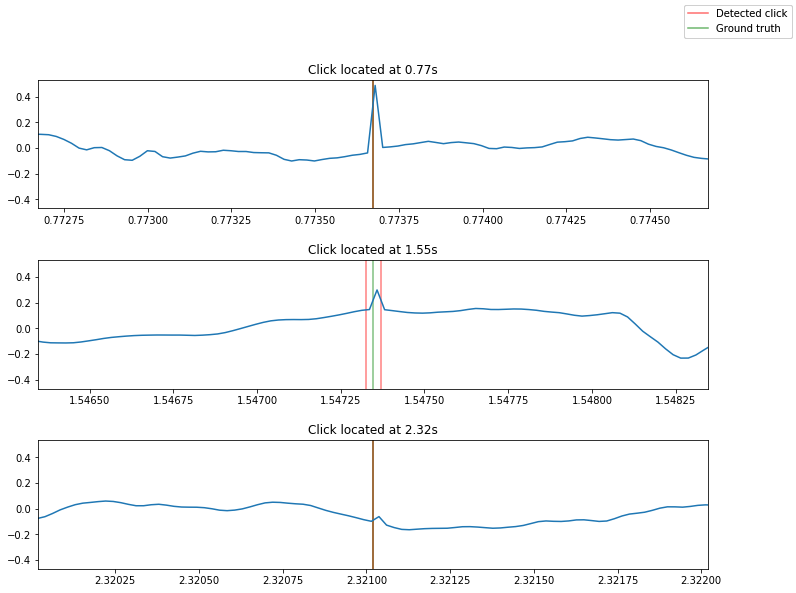

In [11]:
starts, ends = compute(audio)

fig, ax = plt.subplots(len(groundTruth))
plt.subplots_adjust(hspace=.4)
for idx, point in enumerate(groundTruth):
    l1 = ax[idx].axvline(starts[idx], color='r', alpha=.5)
    ax[idx].axvline(ends[idx], color='r', alpha=.5)
    l2 = ax[idx].axvline(point, color='g', alpha=.5)
    ax[idx].plot(times, audio)
    ax[idx].set_xlim([point-.001, point+.001])
    ax[idx].set_title('Click located at {:.2f}s'.format(point))
    
    
    fig.legend((l1, l2), ('Detected click', 'Ground truth'), 'upper right')

# The parameters
this is an explanation of the most relevant parameters of the algorithm

- **detectionThreshold.** This algorithm features an adaptative threshold obtained from the instant power of each frame. This parameter is a gain factor to adjust the algorithm to different kinds of signals. Typically it should be increased for very "noisy" music as hard rock or electric music. The default value was empirically found to perform well in most of the cases. 

- **powerEstimationThreshold.** After removing the auto-regressive part of the input frames through the LPC filter, the residual is used to compute the detection threshold. This signal is clipped to 'powerEstimationThreshold' times its
    median as a way to prevent the clicks to have a huge impact in the estimated threshold. This parameter controls how much the residual is clipped. 

- **order.** The order for the LPC. As a rule of thumb, use 2 coefficients for each format on the input signal. However, it was empirically found that modelling more than 5 formats did not improve the clip detection on music.

- **silenceThreshold.** Very low energy frames can have an unexpected shape. This frame can contain very small clicks that are detected by the algorithm but are impossible to hear. Thus, it is better to skip them with a silence threshold. 